## Preparing the data set

The first step before running the clustering algorithm is to prepare the training and the testing data set. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", color_codes=True)
sns.palplot(sns.color_palette("RdBu", n_colors=7))

fileNameTrain = "C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\train.json\\train.json"
train_df = pd.read_json(fileNameTrain)

fileNameTest = "C:\\Users\\sevda\\Documents\\Data Lab\\Six sigma rental property\\test.json\\test.json"
test_df = pd.read_json(fileNameTest)



As a next step, we will extract the key words from the description variable - by key words, we define words that are in the description of the unit but are not stop words as defined by the ntlk.corpus package.

In [2]:
from nltk.corpus import stopwords

cachedStopWords = stopwords.words("english")

description_key_words_ls = []

for ind, row in train_df.iterrows():
        #print(row['features'])
        #description = description.lower()
        description = row['description'].lower().rstrip(',?!.')
        description = ' '.join([word for word in description.split() if word not in cachedStopWords])
        description_ls = description.split(" ")
        description_key_words_ls += [description_ls]

train_df['description_key_words'] = pd.Series(description_key_words_ls, index=train_df.index)

description_key_words_ls = []

for ind, row in test_df.iterrows():
        #print(row['features'])
        #description = description.lower()
        description = row['description'].lower().rstrip(',?!.')
        description = ' '.join([word for word in description.split() if word not in cachedStopWords])
        description_ls = description.split(" ")
        description_key_words_ls += [description_ls]

test_df['description_key_words'] = pd.Series(description_key_words_ls, index=test_df.index)

We will create two numeric variables which describe the number of features and number of key words in the description section

In [3]:
train_df['num_features'] = train_df.features.apply(len)
train_df['num_key_words_description'] = train_df.description_key_words.apply(len)

test_df['num_features'] = test_df.features.apply(len)
test_df['num_key_words_description'] = test_df.description_key_words.apply(len)

From the Created variable, we will extract into new variables the exact data when the listing was created, the day of year, week of year, weekday and hour.

In [4]:
train_df["created"] = pd.to_datetime(train_df["created"])
train_df["date"]= train_df["created"].dt.date

train_df["dayofyear"] = train_df["created"].dt.dayofyear
train_df["weekofyear"] = train_df["created"].dt.weekofyear
train_df["weekday"] = train_df["created"].dt.weekday
train_df["hour"] = train_df["created"].dt.hour

test_df["created"] = pd.to_datetime(test_df["created"])
test_df["date"]= test_df["created"].dt.date

test_df["dayofyear"] = test_df["created"].dt.dayofyear
test_df["weekofyear"] = test_df["created"].dt.weekofyear
test_df["weekday"] = test_df["created"].dt.weekday
test_df["hour"] = test_df["created"].dt.hour

We will also add the number of photos of each listing as a new variable in the training and testing dataframe.

In [5]:
train_df["num_photos"] = train_df["photos"].apply(len)
test_df["num_photos"] = test_df["photos"].apply(len)


Another step is to create two variables which describe the price per bathroom and price per bedroom. 

In [42]:
train_df["price_per_bathroom"] = train_df["price"]/train_df["bathrooms"]
train_df["price_per_bedroom"] = train_df["price"]/train_df["bedrooms"]

test_df["price_per_bathroom"] = test_df["price"]/test_df["bathrooms"]
test_df["price_per_bedroom"] = test_df["price"]/test_df["bedrooms"]

We will also use the manager id as an indicator of how much interest there may be in a listing based on who is managing the property.

In [37]:
from sklearn import preprocessing

lbl = preprocessing.LabelEncoder()
lbl.fit(list(train_df['manager_id'].values) + list(test_df['manager_id'].values))
train_df['manager_id'] = lbl.transform(list(train_df['manager_id'].values))

test_df['manager_id'] = lbl.transform(list(test_df['manager_id'].values))


lbl = preprocessing.LabelEncoder()
lbl.fit(list(train_df['building_id'].values) + list(test_df['building_id'].values))
train_df['building_id'] = lbl.transform(list(train_df['building_id'].values))

test_df['building_id'] = lbl.transform(list(test_df['building_id'].values))

In [47]:
#print(set(list(test_df['building_id'].values)) & set(list(train_df['building_id'].values)))
train_df.drop(["price_per_bedrooms"], axis=1, inplace=True)
test_df.drop(["price_per_bedrooms"], axis=1, inplace=True)


Some buildings are more often seen in rental ads than others. We will introduce a number of few variables which describe how often the building is been seen in a rental post.

In [72]:
buildings_count = train_df['building_id'].value_counts()

train_df['top_10_building'] = train_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 90)] else 0)
train_df['top_25_building'] = train_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 75)] else 0)
train_df['top_5_building'] = train_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 95)] else 0)
train_df['top_50_building'] = train_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 50)] else 0)
train_df['top_1_building'] = train_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 99)] else 0)
train_df['top_2_building'] = train_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 98)] else 0)
train_df['top_15_building'] = train_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 85)] else 0)
train_df['top_20_building'] = train_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 80)] else 0)
train_df['top_30_building'] = train_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 70)] else 0)

test_df['top_10_building'] = test_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 90)] else 0)
test_df['top_25_building'] = test_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 75)] else 0)
test_df['top_5_building'] = test_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 95)] else 0)
test_df['top_50_building'] = test_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 50)] else 0)
test_df['top_1_building'] = test_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 99)] else 0)
test_df['top_2_building'] = test_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 98)] else 0)
test_df['top_15_building'] = test_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 85)] else 0)
test_df['top_20_building'] = test_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 80)] else 0)
test_df['top_30_building'] = test_df['building_id'].apply(lambda x: 1 if x in buildings_count.index.values[
    buildings_count.values >= np.percentile(buildings_count.values, 70)] else 0)

In [48]:
print(train_df.columns.values)

['bathrooms' 'bedrooms' 'building_id' 'created' 'description'
 'display_address' 'features' 'interest_level' 'latitude' 'listing_id'
 'longitude' 'manager_id' 'photos' 'price' 'street_address'
 'description_key_words' 'num_features' 'num_key_words_description' 'date'
 'dayofyear' 'weekofyear' 'weekday' 'hour' 'num_photos'
 'price_per_bathroom' 'price_per_bedroom']


As a next step in the data preparation, we will explore furthere the description of the rentals.

In [73]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

alg = XGBClassifier(
                     learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=5,
                     min_child_weight=1,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'multi:softprob; num_class=3',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
    
def modelXGBfit(alg, train_df, test_df, predictors, target, target_num_map, cv_folds=5, early_stopping_rounds=50):
    
   
    
    #Fit the algorithm on the data
    #alg.set_params(n_estimators = 3)
    train_target = pd.DataFrame(train_df['interest_level'].apply(lambda x: target_num_map[x]))
    alg.fit(train_df[predictors], train_target)
        
    #Predict training set:
    train_predictions = alg.predict(train_df[predictors])
    train_predprob = alg.predict_proba(train_df[predictors])
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(train_target, train_predictions))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    
    #Predicting on the test data set
    test_predictions = alg.predict(test_df[predictors])
    test_predprob = alg.predict_proba(test_df[predictors])
    return test_predictions, test_predprob, alg


We will use the modelXGBfit function to run the model. The function defines some of the paramteres needed by the xgboost algorithm. We will apply the algorithm to the train data set with the pre selected variables and target variable "interest_level".


Model Report
Accuracy : 0.8784


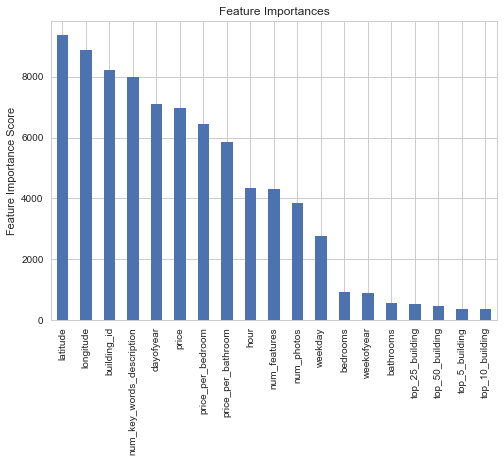

In [74]:
selected_vars  = ["bathrooms", "bedrooms", "price", "num_features", "num_key_words_description",
                   "dayofyear", "weekofyear", "weekday", "hour", "num_photos", "latitude", "longitude",
                    "building_id", "price_per_bathroom", "price_per_bedroom", "top_5_building", "top_10_building",
                    "top_25_building", "top_50_building"]

#neighbourhood_dummies = list(set(neighbourhood_dummies_train) & set(neighbourhood_dummies_test))
#selected_vars.extend(list(neighbourhood_dummies))

target = "interest_level"
target_num_map = {'high':0, 'medium':1, 'low':2}

test_prediction, test_predprob, alg = modelXGBfit (alg, train_df, test_df, selected_vars, target, target_num_map)

Based on the XGBoost algorithm which was trained on the train_df data set, we can see that the trained model has accuracy of 81%. And the strongest predictors used by the model are: price, nm of key words in the desciption (or in other words how long is the description when the stp wprds are removed), day of the year, number of features, hour. Weekday, bedrooms and bathrooms are with less important function when predicting the probabilities the interest level.

In [75]:
out_df = pd.DataFrame(test_predprob)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
print(out_df.head())

       high    medium       low  listing_id
0  0.095755  0.600143  0.304102     7142618
1  0.161312  0.171021  0.667668     7210040
2  0.028792  0.260143  0.711065     7103890
3  0.032066  0.428685  0.539249     7143442
4  0.018609  0.198495  0.782896     6860601


As a next step we will perform cross validation and some fine tuning to the parameters of XGBoost.

##Tune max_depth and min_child_weight

Both parameters are important in the model performance and that's the reason we start with them.

In [76]:
param_test1 = {
 'max_depth': [3, 7, 11],
 'min_child_weight': [1, 3, 5]
}

#selected_vars  = ["bathrooms", "bedrooms", "price", "num_features", "num_key_words_description",
#                   "dayofyear", "weekofyear", "weekday", "hour", "num_photos", "latitude", "longitude"]

#target = "interest_level"
#target_num_map = {'high':0, 'medium':1, 'low':2}

train_target = pd.DataFrame(train_df['interest_level'].apply(lambda x: target_num_map[x]))
    
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1,scoring='log_loss', n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_df[selected_vars],train_target.values.flatten())
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.60151, std: 0.00488, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.60163, std: 0.00487, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.60142, std: 0.00511, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.57454, std: 0.00497, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.57486, std: 0.00473, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.57501, std: 0.00467, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.59328, std: 0.00696, params: {'max_depth': 11, 'min_child_weight': 1},
  mean: -0.58536, std: 0.00607, params: {'max_depth': 11, 'min_child_weight': 3},
  mean: -0.58172, std: 0.00483, params: {'max_depth': 11, 'min_child_weight': 5}],
 {'max_depth': 7, 'min_child_weight': 1},
 -0.5745371709661776)

We will try to further adjust the max_depth based oon the result by looking at other numbers around the final result 7. We will aslo try to adjust further th ethe min_child_weight which was initially set to 1.

In [77]:
param_test1 = {
 'max_depth': [6, 7, 8],
 'min_child_weight': [1,2,3]
}

train_target = pd.DataFrame(train_df['interest_level'].apply(lambda x: target_num_map[x]))
    
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1,scoring='log_loss', n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_df[selected_vars],train_target.values.flatten())
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.57602, std: 0.00438, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -0.57598, std: 0.00404, params: {'max_depth': 6, 'min_child_weight': 2},
  mean: -0.57607, std: 0.00436, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -0.57454, std: 0.00497, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -0.57489, std: 0.00485, params: {'max_depth': 7, 'min_child_weight': 2},
  mean: -0.57486, std: 0.00473, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -0.57477, std: 0.00468, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: -0.57490, std: 0.00435, params: {'max_depth': 8, 'min_child_weight': 2},
  mean: -0.57434, std: 0.00501, params: {'max_depth': 8, 'min_child_weight': 3}],
 {'max_depth': 8, 'min_child_weight': 3},
 -0.5743366720691185)

Since we've got as a result 8, we will try again with few other max depth values: 8,9,10 to see if we can find a better fit. The min_child_weight will be again 2 or 3

In [78]:
param_test1 = {
 'max_depth': [8,9,10],
 'min_child_weight': [3,4,5]
}

train_target = pd.DataFrame(train_df['interest_level'].apply(lambda x: target_num_map[x]))
    
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1,scoring='log_loss', n_jobs=4,iid=False, cv=5)
gsearch1.fit(train_df[selected_vars],train_target.values.flatten())
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.57434, std: 0.00501, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: -0.57441, std: 0.00481, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: -0.57426, std: 0.00482, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: -0.57535, std: 0.00521, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -0.57537, std: 0.00530, params: {'max_depth': 9, 'min_child_weight': 4},
  mean: -0.57570, std: 0.00512, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: -0.57981, std: 0.00509, params: {'max_depth': 10, 'min_child_weight': 3},
  mean: -0.57851, std: 0.00609, params: {'max_depth': 10, 'min_child_weight': 4},
  mean: -0.57746, std: 0.00582, params: {'max_depth': 10, 'min_child_weight': 5}],
 {'max_depth': 8, 'min_child_weight': 5},
 -0.5742567273672895)

 From the results we can see that the optimal value for max depth is 8. Our cross validation was focused on consequitive values between 3 and 11. The optimal value for the minimum child weight is 1. The values for the minimum child weight that we considered were 1, 3 and 5. Since the optimum values are in the middle or the lower end of the intervals we have tested, we will accept max depth = 9 and min child weight = 5 as the best values and will proceed with the rest of the parameter tuning by using these values.

In [79]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=8,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='log_loss', n_jobs=4,iid=False, cv=5)
gsearch3.fit(train_df[selected_vars],train_target.values.flatten())
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.57426, std: 0.00482, params: {'gamma': 0.0},
  mean: -0.57464, std: 0.00497, params: {'gamma': 0.1},
  mean: -0.57517, std: 0.00541, params: {'gamma': 0.2},
  mean: -0.57420, std: 0.00444, params: {'gamma': 0.3},
  mean: -0.57489, std: 0.00489, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 -0.5741994942007341)

We can see that the best gamma value for our data set is 0.1 and not 0 as we initially have selected. We will update the parameters and will run the whole model to see how the updated parameters have affected the final result.


Model Report
Accuracy : 0.9895


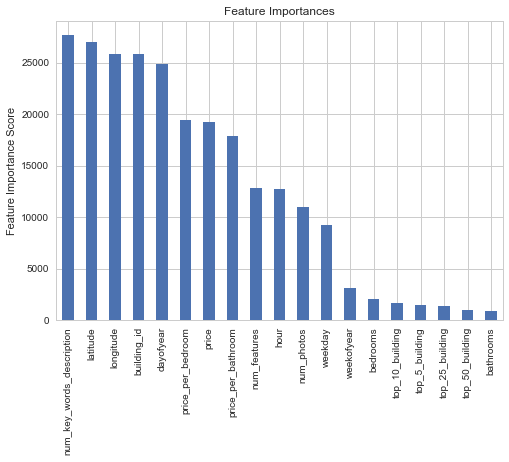

In [80]:
alg = XGBClassifier(
                     learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=8,
                     min_child_weight=5,
                     gamma=0.3,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'multi:softprob; num_class=3',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

test_prediction, test_predprob, alg_result = modelXGBfit (alg, train_df, test_df, selected_vars, target, target_num_map)

We can see that by adjusting the above parameters, we have increased the accuracy of the model from 0.8116 to 0.9751. As a next step we will adjust the "subsample" and "colsample_bytree" parameters.

In [17]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,8)],
 'colsample_bytree':[i/10.0 for i in range(6,8)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=8,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='log_loss', n_jobs=4,iid=False, cv=5)
gsearch4.fit(train_df[selected_vars],train_target.values.flatten())
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -0.59472, std: 0.00580, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: -0.59550, std: 0.00563, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: -0.59310, std: 0.00588, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: -0.59288, std: 0.00526, params: {'colsample_bytree': 0.7, 'subsample': 0.7}],
 {'colsample_bytree': 0.7, 'subsample': 0.7},
 -0.5928809483851276)

We found that the best values are "colsample_bytree" = 0.7 and subsample = 0.7. As a next step we will tune the regularization parameters. The next step is to tune the regularization parameters.

In [66]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

train_target = pd.DataFrame(train_df['interest_level'].apply(lambda x: target_num_map[x]))
    
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=7,
 min_child_weight=1, gamma=0.3, subsample=0.7, colsample_bytree=0.7,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='log_loss', n_jobs=4,iid=False, cv=5)
gsearch6.fit(train_df[selected_vars],train_target.values.flatten())
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -0.57504, std: 0.00473, params: {'reg_alpha': 1e-05},
  mean: -0.57536, std: 0.00493, params: {'reg_alpha': 0.01},
  mean: -0.57547, std: 0.00477, params: {'reg_alpha': 0.1},
  mean: -0.57504, std: 0.00412, params: {'reg_alpha': 1},
  mean: -0.61614, std: 0.00366, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 -0.5750387445126164)

We've got a slight improvement in the cv score compared to the previous parameters. Since our reg_alpha values were pretty wide spread, we will focus on values around 1 to see if we can find an even better adjusted value for reg_alpha.

In [20]:
#Have to remove this code because we found alpha in the previous one
param_test6 = {
 'reg_alpha':[0.5, 1, 3, 5, 10]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=9,
 min_child_weight=5, gamma=0, subsample=0.7, colsample_bytree=0.7,
 objective= 'multi:softprob', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='log_loss', n_jobs=4,iid=False, cv=5)
gsearch6.fit(train_df[selected_vars],train_target.values.flatten())
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -0.59535, std: 0.00576, params: {'reg_alpha': 0.5},
  mean: -0.59476, std: 0.00575, params: {'reg_alpha': 1},
  mean: -0.59308, std: 0.00510, params: {'reg_alpha': 3},
  mean: -0.59302, std: 0.00455, params: {'reg_alpha': 5},
  mean: -0.59577, std: 0.00495, params: {'reg_alpha': 10}],
 {'reg_alpha': 5},
 -0.5930228275842985)

We can see that a better reg alpha parameter is 0.05 and it leads to slightly improvement in the cross validation results. Since we adjusted few more parameters of the model, it is time to see again our model performance. 


Model Report
Accuracy : 0.9775


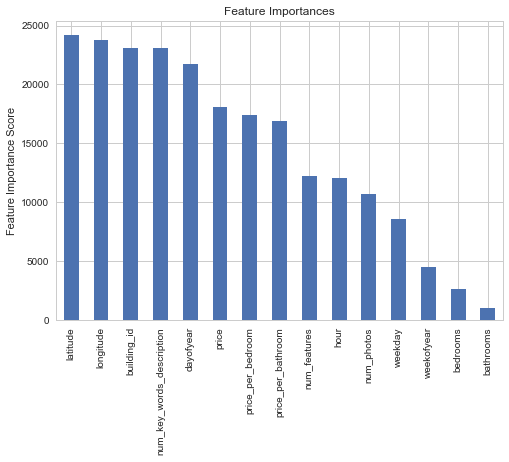

In [67]:
alg = XGBClassifier(
                     learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=7,
                     min_child_weight=1,
                     gamma=0.3,
                     subsample=0.7,
                     colsample_bytree=0.7,
                     reg_alpha = 1e-05,
                     objective= 'multi:softprob; num_class=3',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)

test_prediction, test_predprob, alg_result = modelXGBfit (alg, train_df, test_df, selected_vars, target, target_num_map)

In [81]:
out_df = pd.DataFrame(test_predprob)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb_starter_results_v4.csv", index=False)